In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import final_val

In [2]:
# concentrazioni GuHCl in µM
concentrazioni = np.array([0,1.55, 3.07, 4.63, 6.20, 7.73]) # uM

In [3]:
filename = './data/fondoPBS.TXT'

fondo = pd.read_csv(filename, sep='\t', header=None, skiprows=19)  # Adjust the delimiter if necessary
fondo.columns = ['Wavelength', 'Absorbance']
fondo.tail()


coda_fondo = np.mean(fondo['Absorbance'][fondo['Wavelength'] > 270])

fondo['Absorbance'] = fondo['Absorbance'] - coda_fondo

fondo.to_csv('./data/fondo_processed.csv', index=False)

# plt.title('fondo')
# plt.plot(fondo['Wavelength'], fondo['Absorbance'])
# plt.show()

In [8]:
fig = go.Figure()

colors = px.colors.sequential.Turbo

for i in range(6):
    #spectrum = pd.read_csv(f'./data/C{i}.TXT', sep='\t', header=None, skiprows=19)  # Adjust the delimiter if necessary
    spectrumt2 = pd.read_csv(f'./data/C{i}2.TXT', sep='\t', header=None, skiprows=19)  # Adjust the delimiter if necessary
    #spectrum.columns = ['Wavelength', 'Absorbance']
    spectrumt2.columns = ['Wavelength', 'Absorbance']
    #spectrum = spectrum.dropna()
    spectrumt2 = spectrumt2.dropna()
    
    # tolgo il fondo
    #spectrum['Absorbance'] = spectrum['Absorbance'] - fondo['Absorbance']
    spectrumt2['Absorbance'] = spectrumt2['Absorbance'] - fondo['Absorbance']

    # appaio code:
    # coda = spectrum['Absorbance'][spectrum['Wavelength'] == 340].values[0]
    coda2 = np.mean(spectrumt2['Absorbance'][spectrumt2['Wavelength'] > 270])
    # print(coda2)
    # spectrum['Absorbance'] = spectrum['Absorbance'] - coda
    spectrumt2['Absorbance'] = spectrumt2['Absorbance'] - coda2

    # Export spectrumt2 to CSV for each concentration
    spectrumt2.to_csv(f'./data/C{i}2_processed.csv', index=False)

    #fig.add_trace(go.Scatter(x=spectrum['Wavelength'], y=spectrum['Absorbance'], mode='lines', name=f'C{i}', line_color=colors[i]))
    fig.add_trace(go.Scatter(x=spectrumt2['Wavelength'], y=spectrumt2['Absorbance'], mode='lines', name=f"{np.round(concentrazioni[i],2)}", line_color=colors[i]))

fig.add_trace(go.Scatter(x=fondo['Wavelength'], y=fondo['Absorbance'], mode='lines', name='Fondo', line_color='red', line=dict(dash='dot')))

fig.update_layout(
    xaxis_title='λ [nm]',
    yaxis_title='Absorbance',
    legend_title='Concentration [µM]',
    width=600,
    height=400,
    legend=dict(
        x=1,
        y=1,
        xanchor='right',
        yanchor='top',
    ),
    margin=dict(l=20, r=20, t=20, b=20),
    # xaxis_range=[190, 270]
)

fig.show()


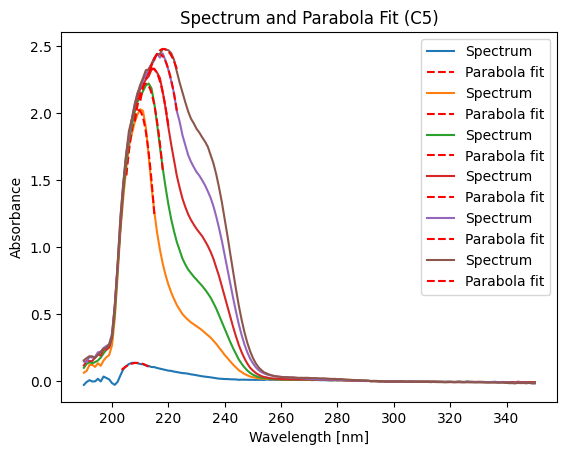

,C [µM],λ0 [nm],σλ [nm],A,σA
0,0.00,208.890909,0.180123,0.138553,0.002591
1,1.55,209.484458,0.111430,2.022840,0.018469
2,3.07,212.042193,0.133724,2.219425,0.012781
3,4.63,214.323443,0.116411,2.332916,0.009303
4,6.20,216.757047,0.129544,2.441302,0.006499
5,7.73,218.305670,0.128637,2.479615,0.007440


In [12]:
import scipy.optimize as sc

def fit_picchi(λ,λ0, a, A):
    return -a*(λ - λ0)**2 + A

A_result = []
sigmaA_result = []
λ_result = []
sigmaλ_result = []

plt.figure()
for i in range(6):
    spectrum = pd.read_csv(f'./data/C{i}2_processed.csv')
    imax = np.argmax(spectrum['Absorbance'])
    λ0 = spectrum['Wavelength'][imax]
    A = spectrum['Absorbance'][imax]
    a = 0.02
    # Fit the peak
    popt, pcov = sc.curve_fit(fit_picchi,spectrum['Wavelength'][imax-5:imax+5], spectrum['Absorbance'][imax-5:imax+5], p0 = [λ0, a, A])

    λ0, a, A = popt
    A_result.append(A)
    λ_result.append(λ0)
    sigmaA = np.sqrt(np.diag(pcov))[2]
    sigmaλ = np.sqrt(np.diag(pcov))[0]
    sigmaA_result.append(sigmaA)
    sigmaλ_result.append(sigmaλ)

    plt.plot(spectrum['Wavelength'], spectrum['Absorbance'], label='Spectrum')
    λ_fit = np.linspace(spectrum['Wavelength'][imax-5], spectrum['Wavelength'][imax+5], 100)
    plt.plot(λ_fit, fit_picchi(λ_fit, *popt), 'r--', label='Parabola fit')
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorbance')
    plt.title(f'Spectrum and Parabola Fit (C{i})')
    plt.legend()
    # print(popt)

λ_result = np.array(λ_result)
sigmaλ_result = np.array(sigmaλ_result)
A_result = np.array(A_result)
sigmaA_result = np.array(sigmaA_result)

results = pd.DataFrame({
    'C [µM]': concentrazioni,
    'λ0 [nm]': λ_result,
    'σλ [nm]': sigmaλ_result,
    'A': A_result,
    'σA': sigmaA_result
})

plt.show()

display(results)

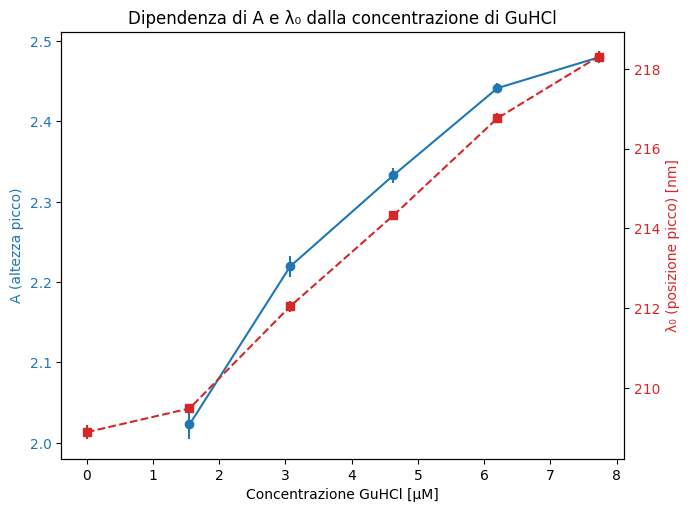

In [14]:
fig, ax1 = plt.subplots(figsize=(7, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Concentrazione GuHCl [µM]')
ax1.set_ylabel('A (altezza picco)', color=color1)
ax1.errorbar(concentrazioni[1:], A_result[1:], yerr=sigmaA_result[1:], fmt='o-', color=color1, label='A (altezza picco)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('λ₀ (posizione picco) [nm]', color=color2)
ax2.errorbar(concentrazioni, λ_result, yerr=sigmaλ_result, fmt='s--', color=color2, label='λ₀ (posizione picco)')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('Dipendenza di A e λ₀ dalla concentrazione di GuHCl')
plt.show()